# Weighted Portfolio

On the first trading day of every month, rebalance portfolio to given percentages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
weights = {'^GSPC': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}
symbols = list(weights.keys())
directions = {'^GSPC': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

use_cache = False

In [4]:
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, use_cache=use_cache)
ts

,^GSPC_high,^GSPC_low,^GSPC_close,TLT_high,TLT_low,TLT_close,GLD_high,GLD_low,GLD_close,TLT_SHRT_high,TLT_SHRT_low,TLT_SHRT_close
date,,,,,,,,,,,,
1927-12-30,17.66,17.66,17.66,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-03,17.76,17.76,17.76,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-04,17.72,17.72,17.72,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-05,17.55,17.55,17.55,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-06,17.66,17.66,17.66,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-13,3235.32,3149.43,3155.22,166.96,165.23,166.88,170.42,169.16,169.40,166.96,165.23,166.88
2020-07-14,3200.95,3127.66,3197.52,168.14,166.98,167.12,170.20,168.81,170.19,168.14,166.98,167.12
2020-07-15,3238.28,3200.76,3226.56,166.95,165.83,166.34,170.43,169.39,170.34,166.95,165.83,166.34


In [5]:
# add calendar columns
ts = portfolio.calendar(ts)

In [6]:
ts, start = portfolio.finalize_timeseries(ts, start)

In [7]:
portfolio.init_trade_logs(ts, capital, margin=2)
pf.TradeLog.instance

{'^GSPC': <pinkfish.trade.TradeLog at 0x7f489d32e5b0>,
 'TLT': <pinkfish.trade.TradeLog at 0x7f489d32e5e0>,
 'GLD': <pinkfish.trade.TradeLog at 0x7f489d32e610>,
 'TLT_SHRT': <pinkfish.trade.TradeLog at 0x7f489d32e2b0>}

In [8]:
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # rebalance on the first trading day of each month
    if row.first_dotm or end_flag:
        #portfolio.print_holdings(date, row)
        for symbol in portfolio.symbols:
            price = portfolio.get_row_column_price(row, symbol)
            weight = 0 if end_flag else weights[symbol]
            direction = directions[symbol]
            portfolio.adjust_percent(date, price, weight, symbol, row, direction)
    # record daily balance
    portfolio.record_daily_balance(date, row)

In [9]:
rlog, tlog, dbal = portfolio.get_logs()

In [10]:
rlog.head()

,date,price,shares,entry_exit,direction,symbol
0,2004-12-01,1191.37,8,entry,LONG,^GSPC
1,2004-12-01,51.47,116,entry,LONG,TLT
2,2004-12-01,45.38,44,entry,LONG,GLD
3,2004-12-01,51.47,38,entry,SHRT,TLT_SHRT
4,2005-01-03,43.02,2,entry,LONG,GLD


In [11]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
351,2016-05-02,115.74,2020-04-01,166.41,50.67,253.37,5,34987.62,LONG,TLT
352,2016-05-02,115.74,2020-04-01,166.41,-50.67,-101.35,2,34886.28,SHRT,TLT_SHRT
353,2016-05-02,2081.43,2020-07-17,3224.73,1143.30,1143.30,1,36029.58,LONG,^GSPC
354,2016-06-01,115.94,2020-04-01,149.45,33.51,100.53,3,36130.11,LONG,GLD
355,2016-06-01,115.94,2020-07-17,170.12,54.18,54.18,1,36184.29,LONG,GLD
...,...,...,...,...,...,...,...,...,...,...
446,2020-06-01,162.09,2020-07-17,166.78,4.69,93.80,20,49914.46,LONG,TLT
447,2020-06-01,163.66,2020-07-17,170.12,6.46,19.38,3,49933.84,LONG,GLD
448,2020-06-01,162.09,2020-07-17,166.78,-4.69,-28.14,6,49905.70,SHRT,TLT_SHRT
449,2020-07-01,163.42,2020-07-17,166.78,3.36,13.44,4,49919.14,LONG,TLT


In [12]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2020-07-13,58626.28,58626.28,58626.28,366,-50264.44,1.86,-
2020-07-14,59475.00,59475.00,59475.00,366,-50264.44,1.85,-
2020-07-15,59898.72,59898.72,59898.72,366,-50264.44,1.84,-
2020-07-16,59702.02,59702.02,59702.02,366,-50264.44,1.84,-
2020-07-17,59912.42,59912.42,59912.42,0,59912.42,1.00,X


In [13]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                   2004-11-18
end                                                     2020-07-17
beginning_balance                                            10000
ending_balance                                            59912.42
total_net_profit                                          49912.42
gross_profit                                              57770.51
gross_loss                                                -7858.09
profit_factor                                                 7.35
return_on_initial_capital                                   499.12
annual_return_rate                                           12.11
trading_period                           15 years 7 months 29 days
pct_time_in_market                                           99.80
margin                                                           2
avg_leverage                                                  1.89
max_leverage                                                  

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

2004-11-18 00:00:00 BUY  115 SPY @ 86.59
2020-07-15 00:00:00 SELL 115 SPY @ 321.85


In [15]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

In [16]:
benchmark.stats = benchmark.get_stats()

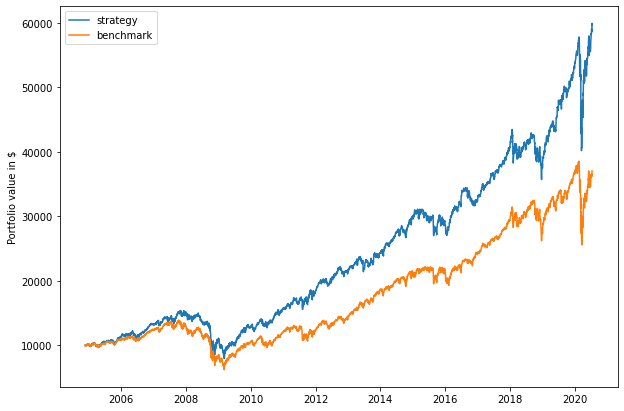

In [17]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

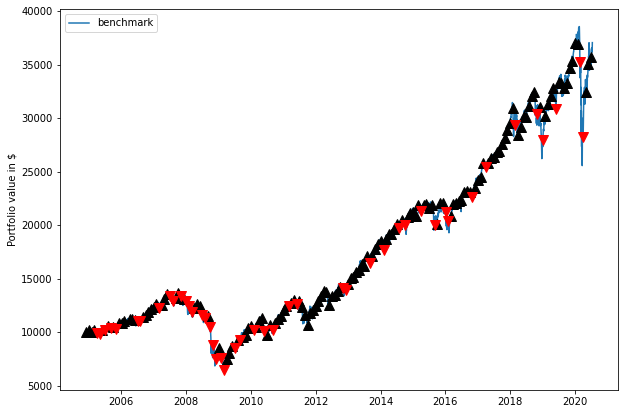

In [18]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

In [19]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$59,912.42","$37,054.49"
total_net_profit,"$49,912.42","$27,054.49"
gross_profit,"$57,770.51","$27,054.49"
gross_loss,"-$7,858.09",$0.00


,strategy,benchmark
annual_return_rate,12.11,8.73
max_closed_out_drawdown,-48.42,-55.02
drawdown_annualized_return,-4.00,-6.31
drawdown_recovery,-1.36,-1.42
best_month,29.50,23.46
worst_month,-30.49,-30.95
sharpe_ratio,0.74,0.53
sortino_ratio,0.91,0.62
monthly_std,4.37,4.57


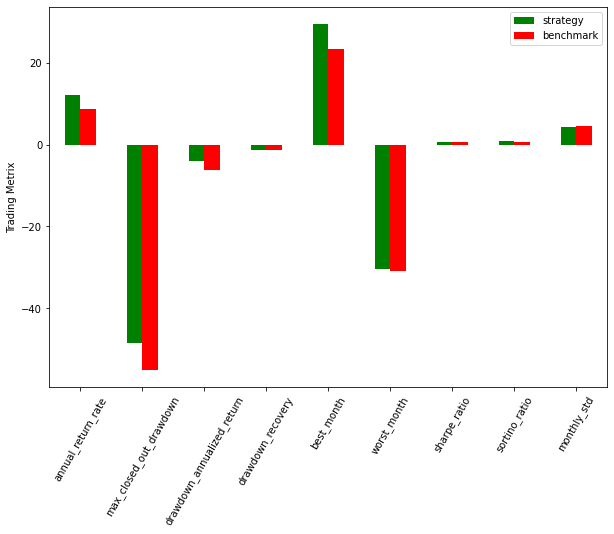

In [20]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df